http://codekata.com/kata/kata05-bloom-filters/

Bloom filters are a 30-year-old statistical way of testing for membership in a set. They greatly reduce the amount of storage you need to represent the set, but at a price: they’ll sometimes report that something is in the set when it isn’t (but it’ll never do the opposite; if the filter says that the set doesn’t contain your object, you know that it doesn’t). And the nice thing is you can control the accuracy; the more memory you’re prepared to give the algorithm, the fewer false positives you get. I once wrote a spell checker for a PDP-11 which stored a dictionary of 80,000 words in 16kbytes, and I very rarely saw it let though an incorrect word. (Update: I must have mis-remembered these figures, because they are not in line with the theory. Unfortunately, I can no longer read the 8” floppies holding the source, so I can’t get the correct numbers. Let’s just say that I got a decent sized dictionary, along with the spell checker, all in under 64k.)

Bloom filters are very simple. Take a big array of bits, initially all zero. Then take the things you want to look up (in our case we’ll use a dictionary of words). Produce ‘n’ independent hash values for each word. Each hash is a number which is used to set the corresponding bit in the array of bits. Sometimes there’ll be clashes, where the bit will already be set from some other word. This doesn’t matter.

To check to see of a new word is already in the dictionary, perform the same hashes on it that you used to load the bitmap. Then check to see if each of the bits corresponding to these hash values is set. If any bit is not set, then you never loaded that word in, and you can reject it.

The Bloom filter reports a false positive when a set of hashes for a word all end up corresponding to bits that were set previously by other words. In practice this doesn’t happen too often as long as the bitmap isn’t too heavily loaded with one-bits (clearly if every bit is one, then it’ll give a false positive on every lookup). There’s a discussion of the math in Bloom filters at www.cs.wisc.edu/~cao/papers/summary-cache/node8.html.

So, this kata is fairly straightforward. Implement a Bloom filter based spell checker. You’ll need some kind of bitmap, some hash functions, and a simple way of reading in the dictionary and then the words to check. For the hash function, remember that you can always use something that generates a fairly long hash (such as MD5) and then take your smaller hash values by extracting sequences of bits from the result. On a Unix box you can find a list of words in /usr/dict/words (or possibly in /usr/share/dict/words). For others, I’ve put a word list up here.1

Play with using different numbers of hashes, and with different bitmap sizes.

Part two of the exercise is optional. Try generating random 5-character words and feeding them in to your spell checker. For each word that it says it OK, look it up in the original dictionary. See how many false positives you get.


Avoiding anything python

https://en.wikipedia.org/wiki/Bloom_filter

https://wiki.python.org/moin/BitManipulation

https://www.jasondavies.com/bloomfilter/


In [1]:
!! wc -l  /usr/share/dict/words


['  235886 /usr/share/dict/words']

In [26]:
!! pip install mmh3

['Collecting mmh3',
 '  Downloading mmh3-2.3.1.tar.gz',
 'Building wheels for collected packages: mmh3',
 '  Running setup.py bdist_wheel for mmh3: started',
 "  Running setup.py bdist_wheel for mmh3: finished with status 'error'",
 '  Complete output from command /Library/Frameworks/Python.framework/Versions/3.5/bin/python3.5 -u -c "import setuptools, tokenize;__file__=\'/private/var/folders/ch/21q6lfkj3zd0gc3zl1cpsfh00000gq/T/pip-build-8nufj3sd/mmh3/setup.py\';exec(compile(getattr(tokenize, \'open\', open)(__file__).read().replace(\'\\r\\n\', \'\\n\'), __file__, \'exec\'))" bdist_wheel -d /var/folders/ch/21q6lfkj3zd0gc3zl1cpsfh00000gq/T/tmp5no60mkfpip-wheel- --python-tag cp35:',
 '  usage: -c [global_opts] cmd1 [cmd1_opts] [cmd2 [cmd2_opts] ...]',
 '     or: -c --help [cmd1 cmd2 ...]',
 '     or: -c --help-commands',
 '     or: -c cmd --help',
 '  ',
 "  error: invalid command 'bdist_wheel'",
 '  ',
 '  ----------------------------------------',
 '  Failed building wheel for mmh3',
 

In [140]:
import mmh3

mmh3.hash('foo') # 32 bit signed int
#-156908512
mmh3.hash64('foo') # two 64 bit signed ints
#(-2129773440516405919, 9128664383759220103)

mmh3.hash('foo', 42) # uses 42 for its seed
#-1322301282

#hash64 and hash_bytes have the third argument for architecture optimization. Use True for x64 and False for x86 (default: True).:
mmh3.hash64('foo', 42, True)
#(-840311307571801102, -6739155424061121879)

mmh3.hash_bytes('foo') # 196 bit value as bytes
#'aE\xf5\x01W\x86q\xe2\x87}\xba+\xe4\x87\xaf~'

b'aE\xf5\x01W\x86q\xe2\x87}\xba+\xe4\x87\xaf~'

In [141]:
import numpy
import random
import mmh3

class BloomFilter():
    def __init__(self, msize=196, k=3):
        self.m = [False]*msize                      # The "present" bits
        self.seeds = random.sample(range(msize), k) # k random, non overlapping, numbers < m
                
        # an array[k] of anon/lambda functions, each using the appropriate seed.
        # hmm. Quick detour into lambdas, closures and scopes. Using seed2=s trick.
        self.hashFunctions = [(lambda word,seed2=s: numpy.uint32( numpy.int32(mmh3.hash(word, seed2)))) for s in self.seeds]

    
    def add(self, testWord):
        for hf in self.hashFunctions:     
            idx = hf(testWord) % len(self.m) # modulo because the size of m is usually less than the uint32 hash
            self.m[idx] = True
    
    def test(self, testWord):
        for hf in self.hashFunctions:
            idx = hf(testWord) % len(self.m) # modulo because the size of m is usually less than the uint32 hash
            if not self.m[idx]:
                return False # Drop out asap
            
        # all masks match
        return True
    
    def reset(self):
        self.m = [False]*len(self.m)
    
    

In [165]:
from io import StringIO
from unittest import *
import string
import random

class BloomFilterTests(TestCase):
    def _junkWord(self, size=6, chars=string.ascii_uppercase + string.digits):
        """
        thx: http://stackoverflow.com/a/2257449
        """
        return ''.join(random.choice(chars) for _ in range(size))
    
    @classmethod
    def setUpClass(self):
        self.bf = BloomFilter()
        self.testWords = ['accessibility','accessoriness','accidentalism',
                          'accidentalist','accidentality','acclimatation','acclimatement' ]
        
    def setUp(self):
        for w in self.testWords:
            #print("Adding test word: %s" %(w))
            self.bf.add(w)
        
        
    
    def test_hashFunctionsPositive(self):
        #Hashing is producing positive ints
        self.assertTrue(self.bf.hashFunctions[0]('qwerty') > 0)
        self.assertTrue(self.bf.hashFunctions[1]('qwerty') > 0)
        self.assertTrue(self.bf.hashFunctions[2]('qwerty') > 0)
        
    def test_hashFunctionsDiffer(self):    
        # Check that the 3 hashes are different - the seeding is working
        self.assertTrue(self.bf.hashFunctions[0]('qwerty') != self.bf.hashFunctions[1]('qwerty'))
        self.assertTrue(self.bf.hashFunctions[1]('qwerty') != self.bf.hashFunctions[2]('qwerty'))
        self.assertTrue(self.bf.hashFunctions[2]('qwerty') != self.bf.hashFunctions[0]('qwerty'))
        
        
        
    def test_bloom_single (self):
        testWord = 'Supercalafragalistic'
        self.bf.add(testWord)
        self.assertTrue(self.bf.test(testWord), "Word %s not found" %(testWord))
        

    def test_bloom_test_present(self):
        for testWord in self.testWords:
            self.assertTrue(self.bf.test(testWord), "Word %s not found" %(testWord))


    def test_bloom_test_absent(self):
        junkWords = [self._junkWord() for x in range(10)]
        for testWord in junkWords:            
            self.assertFalse(self.bf.test(testWord), "False positive: %s present" % (testWord))
            
    def test_reset(self):
        # Make sure the m is extra populated
        for idx in range(10):
            self.bf.add(self._junkWord())
        self.assertTrue(any(self.bf.m))
        
        self.bf.reset()
        self.assertFalse(any(self.bf.m))
        

bft = BloomFilterTests()

suite = TestLoader().loadTestsFromModule(bft)
TextTestRunner().run(suite)

......
----------------------------------------------------------------------
Ran 6 tests in 0.036s

OK


<unittest.runner.TextTestResult run=6 errors=0 failures=0>

In [143]:
!! head -20 /usr/share/dict/words

['A',
 'a',
 'aa',
 'aal',
 'aalii',
 'aam',
 'Aani',
 'aardvark',
 'aardwolf',
 'Aaron',
 'Aaronic',
 'Aaronical',
 'Aaronite',
 'Aaronitic',
 'Aaru',
 'Ab',
 'aba',
 'Ababdeh',
 'Ababua',
 'abac']

In [144]:
!! pip install matplotlib

['Requirement already satisfied (use --upgrade to upgrade): matplotlib in /Users/gregn/Projects/Software/codekatas/venv/lib/python3.5/site-packages',
 'Requirement already satisfied (use --upgrade to upgrade): numpy>=1.6 in /Users/gregn/Projects/Software/codekatas/venv/lib/python3.5/site-packages (from matplotlib)',
 'Requirement already satisfied (use --upgrade to upgrade): pyparsing!=2.0.0,!=2.0.4,>=1.5.6 in /Users/gregn/Projects/Software/codekatas/venv/lib/python3.5/site-packages (from matplotlib)',
 'Requirement already satisfied (use --upgrade to upgrade): cycler in /Users/gregn/Projects/Software/codekatas/venv/lib/python3.5/site-packages (from matplotlib)',
 'Requirement already satisfied (use --upgrade to upgrade): pytz in /Users/gregn/Projects/Software/codekatas/venv/lib/python3.5/site-packages (from matplotlib)',
 'Requirement already satisfied (use --upgrade to upgrade): python-dateutil in /Users/gregn/Projects/Software/codekatas/venv/lib/python3.5/site-packages (from matplot

In [145]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [161]:

bf = BloomFilter(msize=196*196)
i = 1
# Load the first 200 13 letter words into the bloomfilter
with open('/usr/share/dict/words', 'r') as f:
    for w in f.read().split():
        if len(w) == 13:
            bf.add(w)
            i += 1
            print(w)
            if (i> 200):
                break
            

        


abdominoscope
abdominoscopy
abiogenetical
abiologically
aboriginality
abortifacient
abranchialism
absorbability
abstentionist
abstractional
abstractively
abyssopelagic
academization
Acanthocereus
acanthopodous
acanthopteran
acaridomatium
acarocecidium
acatamathesia
acceleratedly
accelerograph
accelerometer
accendibility
acceptability
acceptilation
accessariness
accessaryship
accessibility
accessoriness
accidentalism
accidentalist
accidentality
acclimatation
acclimatement
accombination
accommodately
accommodating
accommodation
accommodative
accompaniment
accorporation
accreditation
acculturation
acenaphthenyl
acetabuliform
acetalization
acetanisidide
acetbromamide
acethydrazide
acetification
acetoarsenite
acetometrical
acetomorphine
acetonization
acetonylidene
acetopiperone
acetothienone
acetylacetone
acetylbenzene
acetylbenzoic
acetylcholine
acetylcyanide
acetylenation
acetylglycine
acetylization
Achaemenidian
achromaticity
achromatocyte
achromatopsia
Achromobacter
achroodextrin
acidif

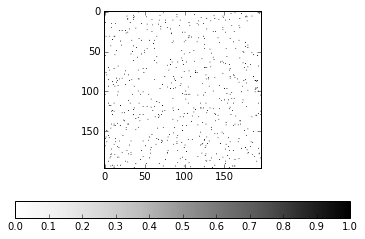

In [166]:
# Resize the m array into a 2D grid for displaying density
arr = (np.resize([x for x in bf.m], (196, 196))).astype('int')
im = plt.imshow(arr, cmap='Greys')
plt.colorbar(im, orientation='horizontal')
plt.show()

In [167]:
def junkWord(size=6, chars=string.ascii_uppercase + string.digits):
    return ''.join(random.choice(chars) for _ in range(size))


i = 1
jw = junkWord(size=13)
while(not bf.test(jw)):
    if(i < 10**6):
        jw = junkWord(size=13)
        i += 1
    else:
        break
        
        
if(bf.test(jw) ):
    print("False positive %s after %d tries" % (jw,i))
else:
    print("No false positives in %d tries" % i)

False positive 96PS9ZXE0Y9U0 after 178441 tries
